In [2]:
from app_store_scraper import AppStore
import pandas as pd
import numpy as np
import json
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,roc_curve, auc
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.utils.fixes import signature
from nltk.corpus import wordnet, stopwords
from nltk import pos_tag, ngrams
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.collocations import * #N-grams
import nltk.collocations #N-grams
from collections import Counter #N-grams
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import string
import seaborn as sns
import matplotlib.pyplot as plt; plt.rcdefaults()
from matplotlib import rc
import missingno as msno #missmap
import numpy as np
import pandas as pd
import os

In [3]:
mysugar = AppStore(country='gb', app_name='mysugr-diabetes-tracker-log', app_id = '516509211')

mysugar.review(how_many=3000)

2022-06-04 18:39:10,188 [INFO] Base - Initialised: AppStore('gb', 'mysugr-diabetes-tracker-log', 516509211)
2022-06-04 18:39:10,189 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/gb/app/mysugr-diabetes-tracker-log/id516509211
2022-06-04 18:39:15,394 [INFO] Base - [id:516509211] Fetched 380 reviews (380 fetched in total)
2022-06-04 18:39:20,791 [INFO] Base - [id:516509211] Fetched 820 reviews (820 fetched in total)
2022-06-04 18:39:26,116 [INFO] Base - [id:516509211] Fetched 1280 reviews (1280 fetched in total)
2022-06-04 18:39:27,840 [INFO] Base - [id:516509211] Fetched 1419 reviews (1419 fetched in total)


In [4]:
mysugar.reviews

[{'title': 'Great fun and functional app !',
  'review': 'Thank you guys this is absolutely wonderful paired with my libre and nightrider it reads the glucose from health app and provides wonderful hba1c estimates that you can see improving real time; making a massive impact ! Being able to use the calculator in a non clunky way unlike meters which can be fiddly this is easy and makes it fun with beautiful easy to read graphics and colours.  Remembers insulin intake that you log also calculates how much carbs to eat to keep your sugars in target if you still have insulin active and your blood is lower than your goal number and thus makes you completely avoid hypos if checked regularly. I hated logging things in before this there was not much of a point to it now theres actual tools that helped me get from 8.4 to 8.0% in 2 weeks ! I have a long way to go but really believe this paired with cgm will change everything for me . Thank you for helping me tame my diabetes monster !  . I highl

In [5]:
df = pd.DataFrame(np.array(mysugar.reviews),columns=['review'])

df2 = df.join(pd.DataFrame(df.pop('review').tolist()))

df2.head()

,title,review,date,rating,userName,isEdited,developerResponse
0,Great fun and functional app !,Thank you guys this is absolutely wonderful pa...,2018-02-20 15:39:32,5,Matzar0z,False,NaN
1,MySugr & Accu Chek mobile,I’m into my first week of using the MySugr app...,2022-02-06 08:52:49,4,footeyabode,False,"{'id': 29567814, 'body': 'Thank you so much fo..."
2,A Diabetic Must,Been using now for 6 weeks after my diabetic r...,2020-07-26 12:55:25,5,Thunderguts,False,NaN
3,So helpful!,I've had multiple issues in the past with trac...,2017-12-03 12:51:12,5,ansaria1,False,NaN
4,Best Diary for Managing your Diabetes,Since having my pancreas removed in February 2...,2019-12-11 12:36:02,5,Stephen Muchow,False,NaN


## Data Integrity

We can see that the fields Title,rating,review,isedited,username,date,developer response. The following can be removed during the data cleaning phase(developerresponse,isedited,username. 

2022-06-04 18:39:28,462 [INFO] numexpr.utils - NumExpr defaulting to 4 threads.


<AxesSubplot:>

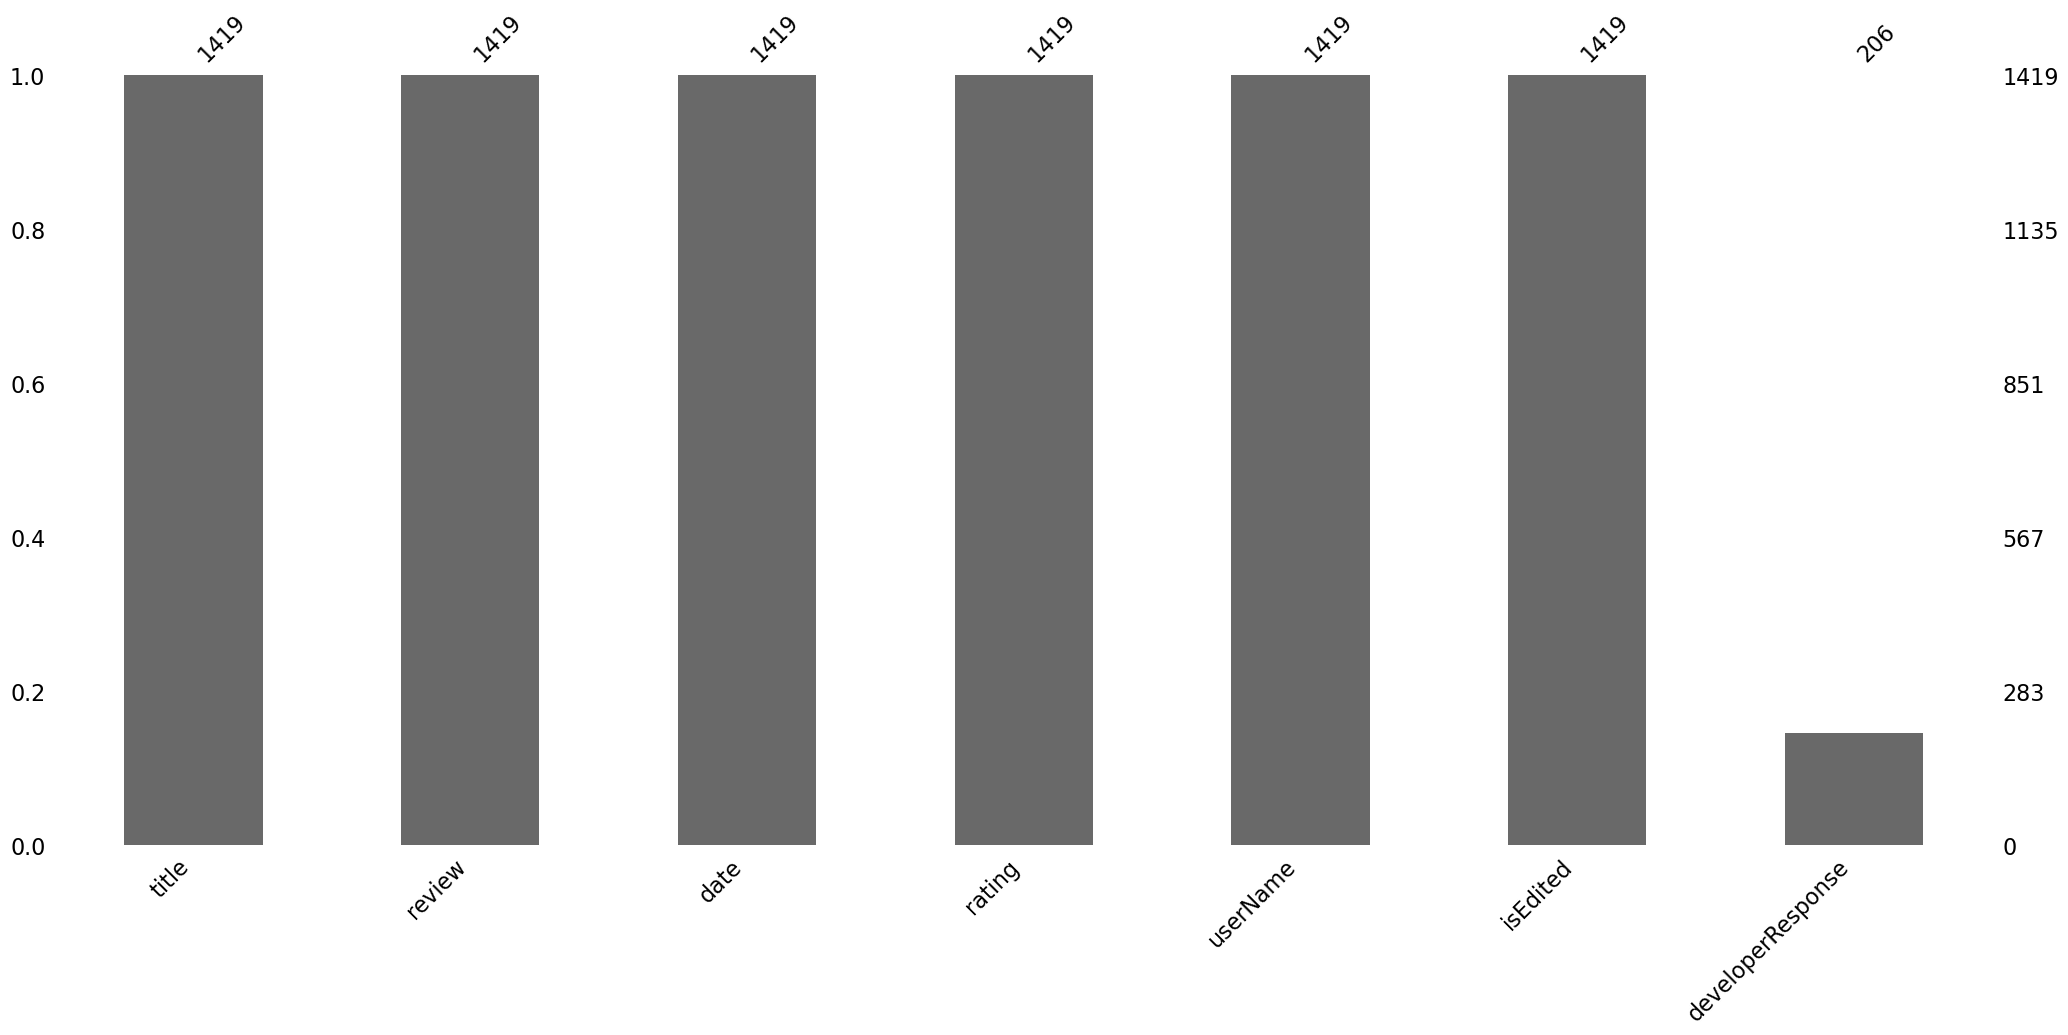

In [6]:
msno.bar(df2)

In [7]:
df2.insert(2, "AppID", ('Mysugar'), True)


## Initial Data Cleaning

To simplify the data, features that are less meaningful to our analysis or are too scarcely populated are removed from the dataset.<br>

>User  – Removed unique identifiers. <br>
>Isedited - tells whether rsponses have been edited or not and holds no significant meaning . <br>
>developerResponse - is scarcely populated and as such can be removed . <br>
>title - tells more on reviews but we already have a reviews column. <br>


In [8]:
df2 = df2.drop(['title','developerResponse','isEdited','userName'], axis=1)
print('Dimensions:',df2.shape)
df2.head()

Dimensions: (1419, 4)


,review,AppID,date,rating
0,Thank you guys this is absolutely wonderful pa...,Mysugar,2018-02-20 15:39:32,5
1,I’m into my first week of using the MySugr app...,Mysugar,2022-02-06 08:52:49,4
2,Been using now for 6 weeks after my diabetic r...,Mysugar,2020-07-26 12:55:25,5
3,I've had multiple issues in the past with trac...,Mysugar,2017-12-03 12:51:12,5
4,Since having my pancreas removed in February 2...,Mysugar,2019-12-11 12:36:02,5


In [9]:
# to change the date format
def get_type_convert(np_type):
    convert_type = type(np.zeros(1,np_type).tolist()[0])
    return (np_type, convert_type)

get_type_convert(df2['date'])

(0      2018-02-20 15:39:32
 1      2022-02-06 08:52:49
 2      2020-07-26 12:55:25
 3      2017-12-03 12:51:12
 4      2019-12-11 12:36:02
                ...        
 1414   2014-11-17 12:51:10
 1415   2015-08-06 09:35:09
 1416   2015-10-24 21:13:14
 1417   2014-07-22 08:24:40
 1418   2014-07-03 12:27:50
 Name: date, Length: 1419, dtype: datetime64[ns],
 int)

In [10]:
# remove duplicates/ for every duplicate we will keep only one row of that type. 
df2.drop_duplicates(subset=['rating','review'],keep='first',inplace=True) 
print(df2.shape)
df2.head()

(1399, 4)


,review,AppID,date,rating
0,Thank you guys this is absolutely wonderful pa...,Mysugar,2018-02-20 15:39:32,5
1,I’m into my first week of using the MySugr app...,Mysugar,2022-02-06 08:52:49,4
2,Been using now for 6 weeks after my diabetic r...,Mysugar,2020-07-26 12:55:25,5
3,I've had multiple issues in the past with trac...,Mysugar,2017-12-03 12:51:12,5
4,Since having my pancreas removed in February 2...,Mysugar,2019-12-11 12:36:02,5


In [11]:
df2["Review"]=df2["review"]
df2.drop(['review'],axis=1,inplace=True)
df2.head()

,AppID,date,rating,Review
0,Mysugar,2018-02-20 15:39:32,5,Thank you guys this is absolutely wonderful pa...
1,Mysugar,2022-02-06 08:52:49,4,I’m into my first week of using the MySugr app...
2,Mysugar,2020-07-26 12:55:25,5,Been using now for 6 weeks after my diabetic r...
3,Mysugar,2017-12-03 12:51:12,5,I've had multiple issues in the past with trac...
4,Mysugar,2019-12-11 12:36:02,5,Since having my pancreas removed in February 2...


## DATA PREPARATION AND CLEANING
My initial attempts at lemmatizing the review text were unsuccessful as a spot check of the corpus showed many words that were not transformed to their base form. Upon further research, it was noted that the default setting for the lemmatization module in NTLK wordnet was ‘noun’ resulting in the transformation of only noun words. To resolve this, the function below defines the word type based on the position tag obtained from the NLTK pos_tag module (the pos_tag module is applied in the clean_text function in the following section)

In [12]:
def get_tag(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [13]:
# import nltk
# nltk.download('stopwords')

In [14]:
# import nltk
# nltk.download('all')

The clean_text function defined below applies the following transformations: <br>
> 1) Change all words to lower case (lemmatization does not work on capitals as they are assumed to be proper nouns). <br>
> 2) Tokenize the text and remove punctuation. <br>
> 3) Remove numeric values. <br>
> 4) Remove stop words (using pre-built stop word dictionary). <br>
> 5) Remove any empty tokens. <br> 
> 6) Apply a position tag to each word and define it based on the previously defined get_tag function as adjective, noun, verb, or adverb.<br>
> 7) Lemmatize the words. <br>
> 8) Remove any single letter words resulting from lemmatization.<br>

In [15]:
import re
def clean_text(text):
    text = text.lower() #change all text to lower case
    text = re.sub(r'\s*(?:https?:\/\/)?[\w.-]+(?:\.[\w.-]+)+[\w\-._~:/?#[\]@!\$&\'\(\)\*\+,;=.]+','',text)
    text = [word.strip(string.punctuation) for word in text.split(" ")] #tokenize and remove punctuation
    text = [word for word in text if not any(c.isdigit() for c in word)] #remove numeric values
    stop = stopwords.words('english') #call english stop word dictionary
    text = [x for x in text if x not in stop]#remove stop words
    text = [t for t in text if len(t) > 0] #remove empty tokens
    pos_tags = pos_tag(text)#apply position tag to text
    text = [WordNetLemmatizer().lemmatize(t[0], get_tag(t[1])) for t in pos_tags] #apply pos_tag function and lemmatize text
    text = [t for t in text if len(t) > 1]# remove single letter words
    text = " ".join(text) #combine
    return(text)


In [16]:
#create new column with cleaned text
df2["reviews_clean"] = df2["Review"].apply(lambda x: clean_text(x))

In [17]:
#Text Before Text Cleaning
print('Before Text Cleaning')
df2['Review'].head()

Before Text Cleaning


0    Thank you guys this is absolutely wonderful pa...
1    I’m into my first week of using the MySugr app...
2    Been using now for 6 weeks after my diabetic r...
3    I've had multiple issues in the past with trac...
4    Since having my pancreas removed in February 2...
Name: Review, dtype: object

In [18]:
#Text Before Text Cleaning
print('After Text Cleaning')
df2['reviews_clean'].head()

After Text Cleaning


0    thank guy absolutely wonderful pair libre nigh...
1    i’m first week use mysugr app new acc-chek mob...
2    use week diabetic review suggest go onto insul...
3    i've multiple issue past track blood sugar oft...
4    since pancreas remove february come term depen...
Name: reviews_clean, dtype: object

In [19]:
# Drop all columns that are blank as a results of the text cleaning function. Lost 176 rows.
print(df2.shape)
df2 = df2[df2['reviews_clean'].map(len) > 0]
print(df2.shape)

(1399, 5)
(1395, 5)


## Plot: Distribution of Reviews by Rating

This plot views the distributions of reviews across all ratings. We can see that the number of positive reviews has the highest number of reviews, causing  our dataset to be imbalanced.

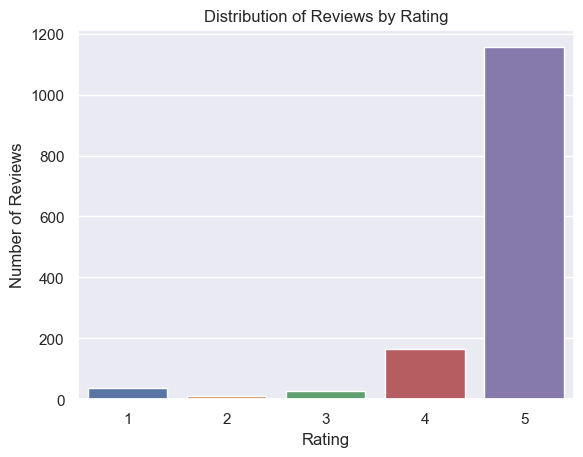

In [20]:
sns.set(style="darkgrid")
bx = sns.countplot(x = "rating", data=df2)
bx.set(xlabel='Rating', ylabel='Number of Reviews',title='Distribution of Reviews by Rating')
plt.show()

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

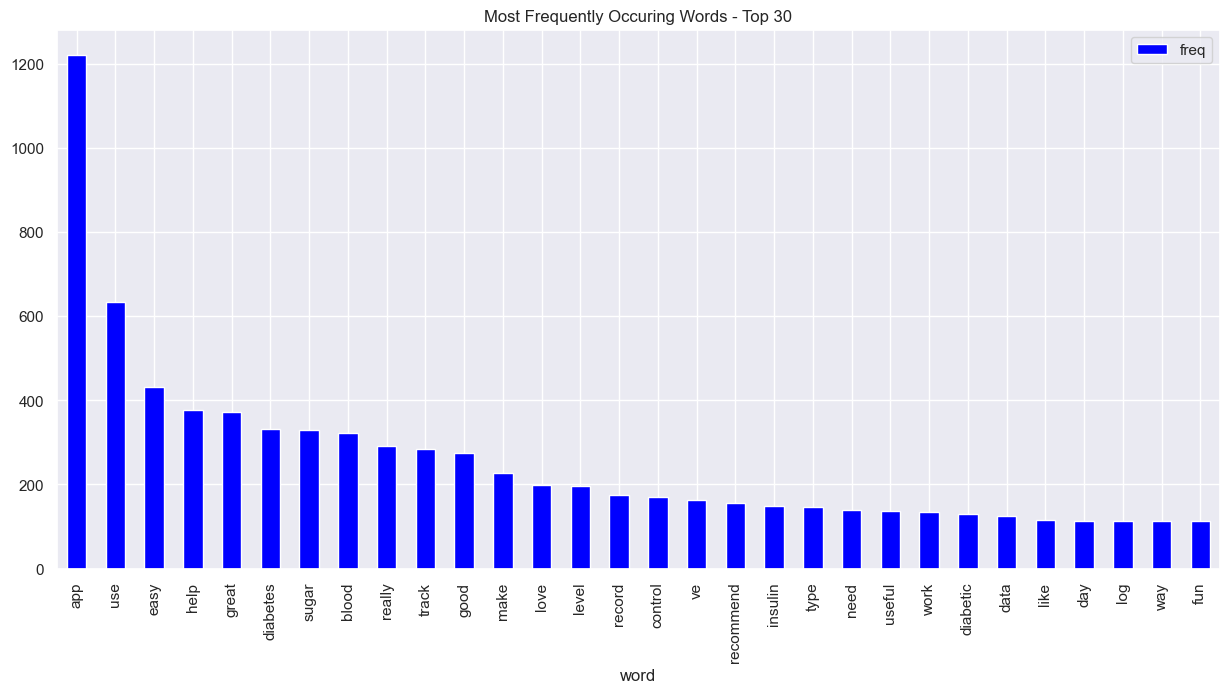

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words = 'english')
words= cv.fit_transform(df2['reviews_clean'].values.astype('U'))

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")

In [22]:
dfn= df2[df2['reviews_clean'].str.contains("app")]
#dfn_pg['Reviews'].head(10)
dfn['reviews_clean'].head(10)

0    thank guy absolutely wonderful pair libre nigh...
1    i’m first week use mysugr app new acc-chek mob...
2    use week diabetic review suggest go onto insul...
3    i've multiple issue past track blood sugar oft...
4    since pancreas remove february come term depen...
5    app change whole look use correctly fill info ...
6    newly diagnose type try make sense change try ...
7    long search best app i’ve see far many feature...
8    app around week seriously think change life tr...
9    app great highly motivate instantly reward yea...
Name: reviews_clean, dtype: object

## FEATURE ENGINEERING
Sentiment Analysis
The Vader module from NLTK was the model selected for sentiment analysis. The Vader module uses a prebuilt lexicon of words to calculate a sentiment score. This module was selected for sentiment analysis because the module takes into consideration the context of the text. The module returns 4 values: positivity score, neutrality score, negativity score and summary score.

In [23]:
sid = SentimentIntensityAnalyzer()
#calculates the negativity,  neutrality, positivity and overall sentiment scores
df2["sentiments"] = df2["reviews_clean"].apply(lambda x: sid.polarity_scores(x))
#drop sentiment column and add the 4 sentiment scores as separate features to primary dataset
df2 = pd.concat([df2.drop(['sentiments'], axis=1), df2['sentiments'].apply(pd.Series)], axis=1)
df2[['AppID','rating','reviews_clean','neg','neu','pos','compound']].head(10)

,AppID,rating,reviews_clean,neg,neu,pos,compound
0,Mysugar,5,thank guy absolutely wonderful pair libre nigh...,0.039,0.621,0.340,0.9876
1,Mysugar,4,i’m first week use mysugr app new acc-chek mob...,0.022,0.738,0.240,0.9805
2,Mysugar,5,use week diabetic review suggest go onto insul...,0.060,0.738,0.202,0.9665
3,Mysugar,5,i've multiple issue past track blood sugar oft...,0.000,0.668,0.332,0.9871
4,Mysugar,5,since pancreas remove february come term depen...,0.000,0.757,0.243,0.9578
5,Mysugar,5,app change whole look use correctly fill info ...,0.055,0.799,0.146,0.7346
6,Mysugar,5,newly diagnose type try make sense change try ...,0.081,0.707,0.212,0.8625
7,Mysugar,5,long search best app i’ve see far many feature...,0.012,0.689,0.300,0.9812
8,Mysugar,5,app around week seriously think change life tr...,0.153,0.606,0.241,0.7501
9,Mysugar,5,app great highly motivate instantly reward yea...,0.061,0.566,0.373,0.9838


The graph below shows the compound sentiment calculated by Vader distributed by good and bad reviews. We can see that good reviews are mostly considered very positive by Vader, whereas, bad reviews are more dispersed with a slightly higher proportion of negative reviews with negative sentiment scores. The only variation to this trend is the slight peak around the neutral compound score (zero) for both negative and positive reviews.

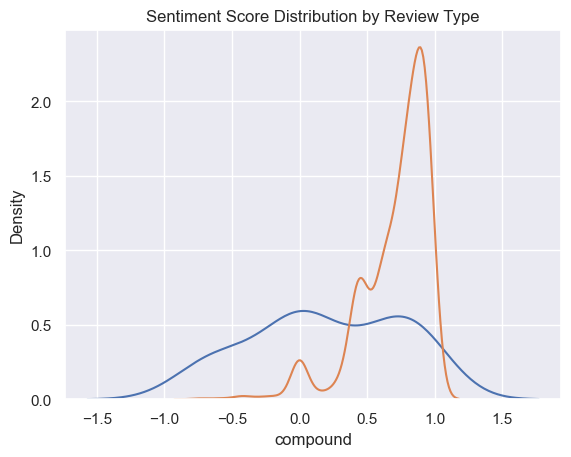

In [24]:
for x in [1, 5]:
    subset = df2[df2['rating'] == x]
    if x > 3:
        label = "Postive Review"
    else:
        label = "Negative Review"    
    sns.distplot(subset['compound'], hist = False, label = label).set_title('Sentiment Score Distribution by Review Type')



### Word and Character Count Features

Two new features are created by extracting the number of characters and number of words per review. Log transformation is applied to pull in outliers.



In [25]:
df2["num_chars"] = df2["reviews_clean"].apply(lambda x: len(x))
df2["num_words"] = df2["reviews_clean"].apply(lambda x: len(x.split(" ")))
#log transformation
df2['num_chars1'] = np.log(df2['num_chars'])
df2['num_words1'] = np.log(df2['num_words'])

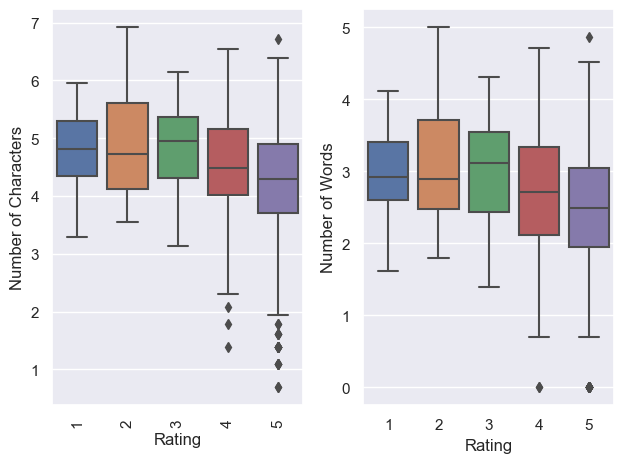

In [26]:
x1 = df2['rating']
x2 = df2['rating']
y1 = df2['num_chars1']
y2 = df2['num_words1']
#plot num_chars by rating in column 1
plt.subplot(1, 2, 1)
plt.xticks(rotation=90)
g = sns.boxplot(x1, y1)
g.set(xlabel='Rating', ylabel='Number of Characters',title='')
#plot num_words by rating in column 2
plt.subplot(1, 2, 2)
g = sns.boxplot(x2, y2)
g.set(xlabel='Rating', ylabel='Number of Words',title='')

plt.tight_layout()
plt.show()

We can see a trend forming from the boxplot below, where users tend to leave longer reviews for negative ratings (<3) and neutral ratings (=3) and shorter reviews good review (>3). This may be a useful feature for our predictive models

### Doc2Vec Feature Creation

The doc2vec method from the Genism module is used to generate document vectors for each cleaned review. The doc2vec module uses a modified word2vec model with the addition of a document unique vector, which numerically represents the document. This provides a document-concept representation of each review. This feature is important for training our model since similar texts should have similar vector representations. We first start by creating doc2vec vector columns and then proceed to train the model. The model is then applied to the text to transform each review into vector data before being combined with our original dataframe.

Warning Message to install compiler to speed up genism is not necessary for the size of data used in this notebook. For larger data, a compiler would be recommended as this model took roughly 26 minutes to run.

In [27]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df2["reviews_clean"].apply(lambda x: x.split(" ")))]
# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=6, window=2, min_count=1, workers=4)
# transform each document into a vector data
df_vector = df2["reviews_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
df_vector.columns = ["df_vector_" + str(x) for x in df_vector.columns]
df2 = pd.concat([df2, df_vector], axis=1)

2022-06-04 18:39:41,532 [INFO] gensim.models.doc2vec - collecting all words and their counts
2022-06-04 18:39:41,534 [INFO] gensim.models.doc2vec - PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
2022-06-04 18:39:41,556 [INFO] gensim.models.doc2vec - collected 2999 word types and 1395 unique tags from a corpus of 1395 examples and 24486 words
2022-06-04 18:39:41,559 [INFO] gensim.models.word2vec - Creating a fresh vocabulary
2022-06-04 18:39:41,587 [INFO] gensim.utils - Doc2Vec lifecycle event {'msg': 'effective_min_count=1 retains 2999 unique words (100.00% of original 2999, drops 0)', 'datetime': '2022-06-04T18:39:41.586977', 'gensim': '4.2.0', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'prepare_vocab'}
2022-06-04 18:39:41,592 [INFO] gensim.utils - Doc2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 24486 word corpus (100.00% of original 24486, drops 0)', 'datetime'

### Term Frequency - Inverse Document Frequency

The word frequency is calculated using the TF-IDF model. In addition to just counting word frequency, this model computes the relative importance of each word based on the frequency of occurrence of the word in each text. A column is generated for every word which occurs in a minimum of 10 different documents to provide a relative filter on importance and to remove size. This can be adjusted to fine tune the predictive models.



In [28]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(df2["reviews_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = df2.index
df2 = pd.concat([df2, tfidf_df], axis=1)

In [29]:
df2.shape

(1395, 384)

### Define Good and Bad Reviews

The final feature created is to define a bad review ( rating < 3) by denoting it with 0 and all other ratings with 1. For the purposes of our model, the neutral reviews (rating of 3) are separated into another dataframe. Our dataset is relatively imbalanced with 96% good review and 3.4% bad reviews oversampling of our dataset would take care of the imbalanced to make it a balanced dataset.

In [30]:
df2['label'] = np.where(df2['rating']<3, 0, 1)
#take lowest and highest rating
df_class = df2[(df2['rating'] < 3) | (df2['rating'] > 3)]
df_neutral = df2[(df2['rating'] == 3)].drop(['label'], axis=1)
df_class = df_class.sort_values(by=['rating'])
print ("Dimenions:", df_class.shape)
print ("Good (1) vs Bad (0) split:" "\n",df_class["label"].value_counts(normalize = True))
df_class.groupby('label').count()

Dimenions: (1369, 385)
Good (1) vs Bad (0) split:
 1    0.965668
0    0.034332
Name: label, dtype: float64


,AppID,date,rating,Review,reviews_clean,neg,neu,pos,compound,num_chars,...,word_wish,word_within,word_without,word_work,word_worth,word_would,word_write,word_year,word_yet,word_you
label,,,,,,,,,,,,,,,,,,,,,
0,47,47,47,47,47,47,47,47,47,47,...,47,47,47,47,47,47,47,47,47,47
1,1322,1322,1322,1322,1322,1322,1322,1322,1322,1322,...,1322,1322,1322,1322,1322,1322,1322,1322,1322,1322


## MODEL DEVELOPMENT

The Random Forest model (RF) is used to predict if a review is good or bad given the various features we created from the review text. The model will then be used on the neutral dataset (rating = 3) to categorize the reviews.


### Random Forest Classifier

The features used to train the RF model are selected and any columns to be ignored are defined. The dataset is then split into training and test datasets.

In [31]:
# feature selection
label = "label"
ignore_cols = [label, "Review", "reviews_clean", "date", "AppID","rating"]
features = [c for c in df_class.columns if c not in ignore_cols]
# split the data into train and test
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_class[features], df_class[label], test_size = 0.3, random_state = 42)

The resultant dataset for training is 958 rows x 392 columns and the test dataset is 411 rows x 392 columns. The 70/30 split was used as the app dataset is relatively small.

In [32]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (958, 379)
Training Labels Shape: (958,)
Testing Features Shape: (411, 379)
Testing Labels Shape: (411,)


## Balancing our label class

In [33]:
from imblearn.over_sampling import SMOTE

In [34]:
oversample = SMOTE()
X_train_ns,y_train_ns = oversample.fit_resample(X_train,y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_ns)))

The number of classes before fit Counter({1: 918, 0: 40})
The number of classes after fit Counter({1: 918, 0: 918})


imblearn is used to balance our label class using over sampling method so our model would not be biased when prediting and it would be able to predict well on new dataset. Our inital label class was 0: 40, 1: 918 after imblearn was used we had 0: 918, 1: 918 ratio 50:50 making it a balanced dataset.

## The RF model is trained and cross validation is run to get a better overview of our model's performance..

In [35]:
# train a random forest classifier
rf = RandomForestClassifier(n_estimators = 20, random_state = 42)
rf.fit(X_train_ns,y_train_ns)
#Cross Validation Score
rfc_cv_score = cross_val_score(rf, df_class[features], df_class[label], cv=10, scoring= 'roc_auc')

we use pickle libiary to save our model to avoid retraining everytime we work on our dataset 

In [36]:
import pickle
with open('random_forest_classifier2.pickle','wb') as f:#saving our model
    pickle.dump(rf,f)

# pickle_in= open('random_forest_classifier1.pickle','rb')# opening our model
# clf= pickle.load(pickle_in)

In [37]:
print('CONFUSION MATRIX')
print(confusion_matrix(y_test, rf.predict(X_test)))
print('\n')
print (pd.crosstab(y_test, rf.predict(X_test), rownames=['Actual Result'], colnames=['Predicted Result']))
print('\n')
print('CLASSIFICATION REPORT')
print(classification_report(y_test, rf.predict(X_test)))
print('\n')
print('ALL AUC SCORES')
print(rfc_cv_score)
print('\n')
print('MEAN AUC SCORE: ', rfc_cv_score.mean())

CONFUSION MATRIX
[[  3   4]
 [  3 401]]


Predicted Result  0    1
Actual Result           
0                 3    4
1                 3  401


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.50      0.43      0.46         7
           1       0.99      0.99      0.99       404

    accuracy                           0.98       411
   macro avg       0.75      0.71      0.73       411
weighted avg       0.98      0.98      0.98       411



ALL AUC SCORES
[0.75984848 0.84166667 0.84242424 0.98181818 0.77878788 0.98939394
 0.83333333 0.79793233 0.98778195 0.97253788]


MEAN AUC SCORE:  0.8785524891774891


### Model Evaluation

## overall accuracy 0.98

#### Confusion Matrix:
The RFC model predicted 399 reviews as good incorrectly and 4 review as bad incorrectly.

#### Classification Report:
The model achieved an average precision of 0.72, average recall of 0.78 and average accuracy of 0.75. We can see the model has higher precision when it comes to predicting positive review. This may be because the positive sentiment is one of most important feature for our model (refer to Feature Importance section).

#### Cross Validated (CV) AUC Score:
The model achieved an average CV AUC score of 0.87 which indicates a relatively good model.



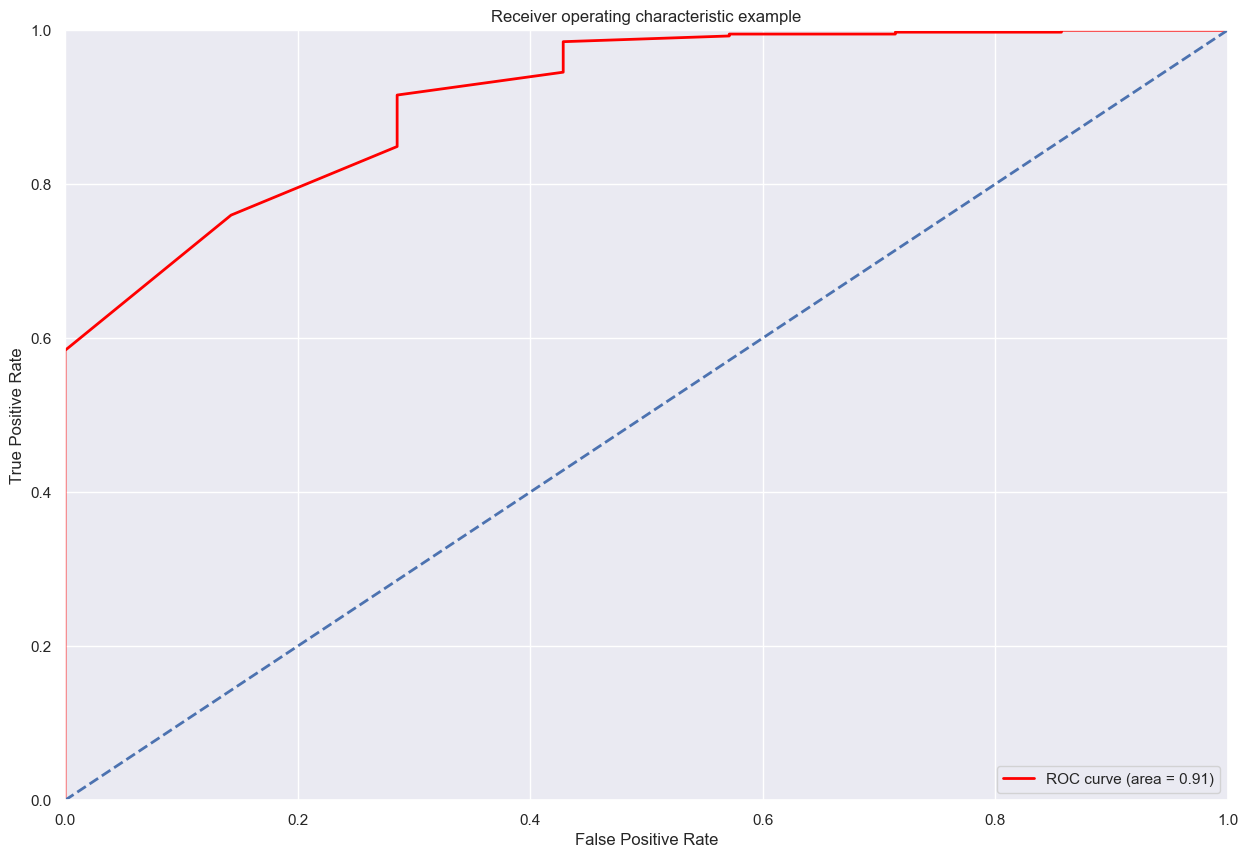

In [38]:
y_pred = [x[1] for x in rf.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)
roc_auc = auc(fpr, tpr)
plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Precision Recall Curve (Average Precision)

The PR curve shows the calculated precision and recall at various threshold values. The precision values for our model remain relatively stable at each threshold AP= 0.97. <br>
> Precision (positive prediction value) is the ratio of TP/ (TP + FP) <br>
> Recall (sensitivity) is the ratio of TP/(TP + FN) <br>

Note: The PR curve is useful for dataset that are imbalanced. 



In [39]:
!pip install funcsigs

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=1.00')

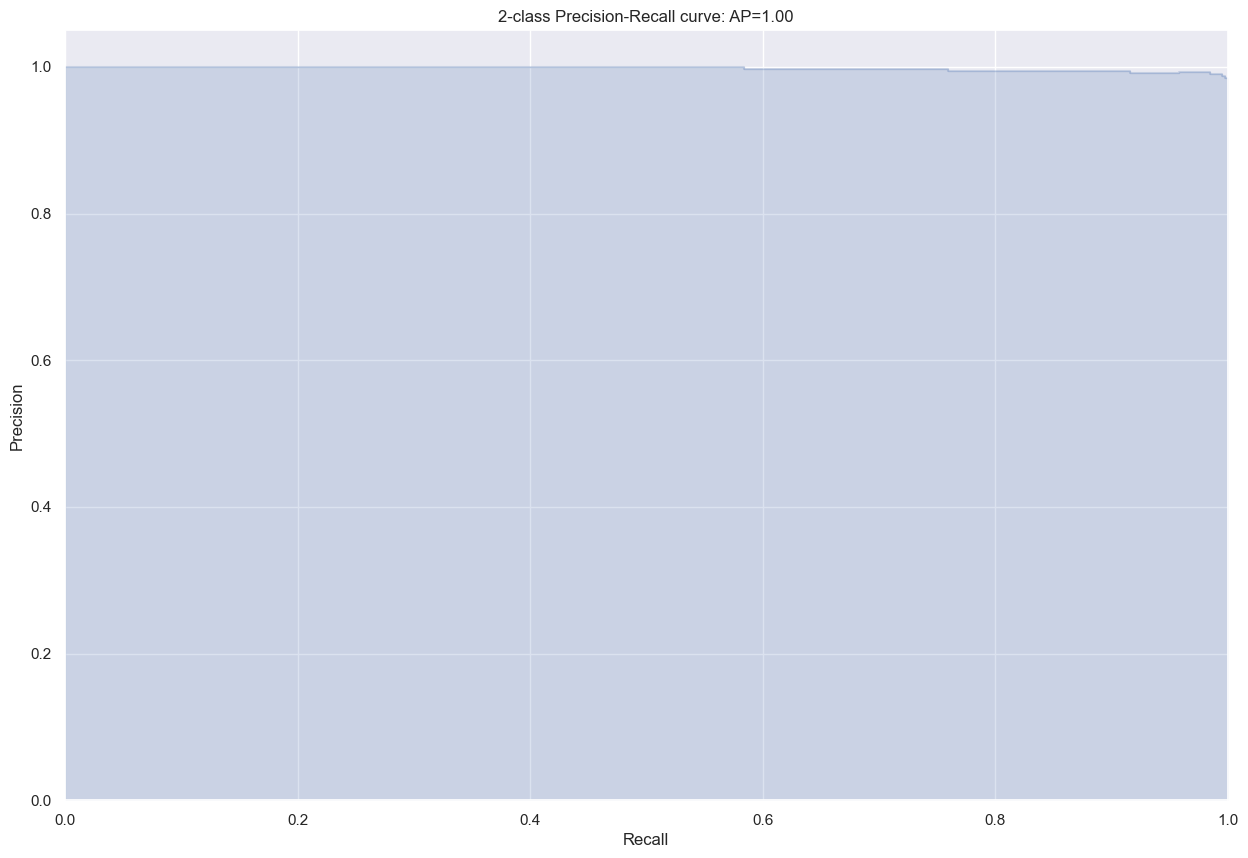

In [40]:
from funcsigs import signature
average_precision = average_precision_score(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

### Feature Importance

The most important features were the 4 sentiment scores generated by Vader,the doc2vec, the number of words and characters  features. Additionally, some words identified by TF-IDF such as “app” and "good" have fairly high importance, also may be correlated with the Vader “pos” scores and the words identified by TF-IDF such as "bad" may be correlated with the Vader “neg” scores, while the words dentified by TF-IDF such as "update","download", "can" may be correlated with the Vader “neu” scores.

In [41]:
# show feature importance
feature_importances_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head(20)

,feature,importance
0,neg,0.167119
2,pos,0.114369
3,compound,0.054699
11,df_vector_3,0.050896
337,word_time,0.021854
50,word_blood,0.021289
107,word_easy,0.020213
16,word_accu,0.019021
1,neu,0.016914
13,df_vector_5,0.015724


## Model Application

The RF model is applied to the dataset with ratings of 3 to determine if the reviews are good or bad.

In [42]:
df_temp = df_neutral[['date','AppID','rating','Review','reviews_clean']]
df_neutral = df_neutral.drop(['Review','reviews_clean','date','AppID','rating'], axis=1)
df_neutral['prediction'] = rf.predict(df_neutral)
df_neutral = pd.concat([df_temp.reset_index(drop=True),df_neutral.reset_index(drop=True)], axis=1)

In [43]:
print('Predicted Good Reviews')
dfn_pred_good = df_neutral[(df_neutral['prediction'] == 1)]
dfn_pred_good['Review'].head(20)

Predicted Good Reviews


0     Ok app. Not enough choices and options for dat...
1     This App is helping me chart my blood glucose ...
2     This app is really useful. I’ve always found r...
4     I struggle to understand with symbols and sque...
5     Though the support team are available, I have ...
6     Daily challenges don’t work on a daily basis b...
7     The functionalities of the app is great and is...
8     I like the app but the additional features I w...
9     Let me see how much active insulin I have at a...
10    This is the best app I’ve used for diabetes.  ...
11    Use for tracking my daily blood sugars and get...
12    Once I’d worked out how to record things it be...
14    Fantastic app I love it, my only gripe is that...
15    Useful app, but could be improved by showing i...
16    As title, upon launch green opening screen and...
17    Early days, waiting for it to talk to my meter...
18               Still waiting to get a average reading
19    Need to add other icons for exercise such 

### Predicted Bad Reviews

For the most part, the model seems to have done a pretty good job of categorizing the neutral reviews. Based on the preview we can see a couple of issues being highlighted by reviewers:

In [44]:
print('Predicted bad Reviews')
dfn_pred_bad = df_neutral[(df_neutral['prediction'] == 0)]
dfn_pred_bad['Review'].head(50)

Predicted bad Reviews


3     I have used this app for some time, recently t...
13    I find the app a helpful guide regarding corre...
21    On the whole a decent app, few frustrations th...
24    Like many apps of this type.  This has a major...
Name: Review, dtype: object

## REVIEW INSIGHTS

Now that we have our cleaned review data and have split the neutral ratings into good or bad categories. We can examine the text to see what insights we can gather.

### Word Cloud

The word cloud is a visual representation of word frequency. We can immediately identify some key app services that seem to be important to customers, such as easy, good and opay. This method is somewhat controversial as it is difficult to interpret relative size (and therefore frequency) of words. It is also difficult to interpret context when isolated words are presented, such as in the case of "time, service, ride and work" which can be positive or negative.

In [186]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=dfn_pred_good
WC=wordcloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

NameError: name 'wordcloud' is not defined

<Figure size 1000x1000 with 0 Axes>

## Preview Predicted Reviews

### Predicted Good Reviews

- The predicted good review preview seems to be less insightful, but this is somewhat expected given the high neutrality score noted during the Vader sentiment step. 

We noted that our model weighed positive words heavily in feature importance, which would explain these results. 



In [7]:

glucosebuddy = AppStore(country='gb', app_name='glucose-buddy-diabetes-tracker', app_id = '294754639')

glucosebuddy.review(how_many=3000)

2022-06-04 12:45:31,361 [INFO] Base - Initialised: AppStore('gb', 'glucose-buddy-diabetes-tracker', 294754639)
2022-06-04 12:45:31,362 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/gb/app/glucose-buddy-diabetes-tracker/id294754639
2022-06-04 12:45:33,632 [INFO] Base - [id:294754639] Fetched 183 reviews (183 fetched in total)


In [8]:
glucosebuddy.reviews

[{'date': datetime.datetime(2018, 9, 11, 20, 29, 30),
  'userName': 'Parky1967',
  'isEdited': False,
  'title': '? Update bugs are really annoying',
  'review': 'I had been using this app for ages and was happy enough with it. Since the recent upgrade it displays multiple duplicate records (bm, steps etc).\n\nThis needs to be fixed or I’m switching.....',
  'rating': 5},
 {'date': datetime.datetime(2017, 10, 26, 7, 0, 20),
  'userName': 'Kemilly3',
  'isEdited': False,
  'title': 'New update just shoves ads onto the homepage',
  'review': "Very disappointed. In an attempt to make some cash, ads are being displayed on the home page making it almost impossible to update readings synced from the health app. If you are going to introduce ads at least consider UX so that your app isn't rendered completely useless. \n\nI understand wanting to push premium but there are less annoying ways to do this. \n\nThis coupled with no integration with MyFitnessPal means I'm not likely to keep trying t

In [9]:


diabetes = AppStore(country='gb', app_name='diabetes-m', app_id = '1196733537')

diabetes.review(how_many=3000)

2022-06-04 12:45:34,453 [INFO] Base - Initialised: AppStore('gb', 'diabetes-m', 1196733537)
2022-06-04 12:45:34,454 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/gb/app/diabetes-m/id1196733537
2022-06-04 12:45:34,710 [INFO] Base - [id:1196733537] Fetched 18 reviews (18 fetched in total)


In [10]:
diabetes.reviews

[{'isEdited': False,
  'userName': 'West country viewer.',
  'title': 'Judith Boyce',
  'rating': 5,
  'date': datetime.datetime(2018, 11, 22, 21, 4, 49),
  'review': 'I have used this app for 2+ years. If one pays the premium and uses the app to work out your insulin calculations for you once you have put in your ratios it is excellent and can be synced to your phone. \nI absolutely love it. No gimmicky inputs.'},
 {'isEdited': False,
  'userName': 'Sep139',
  'title': 'Ok when it works',
  'rating': 3,
  'date': datetime.datetime(2021, 8, 28, 18, 23, 28),
  'review': 'Had this app since March, to start with it was ok but the past few weeks all it does is either crash or the app won’t even open. Have contacted directly and did receive a reply saying it is something that is happening only to some iPhone models and they are trying to fix. Really frustrating as I was getting the hang of the app and now it doesn’t want to work.'},
 {'isEdited': False,
  'userName': 'Gravypie16',
  'title'

In [11]:

onedropdiabetes = AppStore(country='gb', app_name='one-drop-diabetes-management', app_id = '972238816')

onedropdiabetes.review(how_many=3000)

2022-06-04 12:45:35,685 [INFO] Base - Initialised: AppStore('gb', 'one-drop-diabetes-management', 972238816)
2022-06-04 12:45:35,686 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/gb/app/one-drop-diabetes-management/id972238816
2022-06-04 12:45:36,893 [INFO] Base - [id:972238816] Fetched 97 reviews (97 fetched in total)


In [12]:
onedropdiabetes.reviews

[{'isEdited': False,
  'date': datetime.datetime(2020, 10, 11, 8, 47, 53),
  'rating': 4,
  'review': 'Looked promising to be five stars at first but as you can only select medications in the list not add generic ones used in the UK like Perindopril so I am knocking one star off. Otherwise it is what the Apple Health app should be for collating health data. I use a ContourNext Bluetooth glucose monitor and get the test strips on NHS prescription. Whilst the OneDrop app does not connect directly with the reader it does through the ContourNext app & Apple Health app so all the data ends up in one place. The food library is just as good if not better than some apps I’ve tried for recording my carbs. I am a health professional and don’t need the coaching so the constant promotions can be a bit frustrating but are far less intrusive than some other apps I’ve tried. I am lucky to be well supported by colleges, I’m sure the coaching is invaluable for some users. I would be happy to pay a a do

In [13]:

dariohealth = AppStore(country='gb', app_name='dario-health', app_id = '571322125')

dariohealth.review(how_many=3000)

2022-06-04 12:45:37,532 [INFO] Base - Initialised: AppStore('gb', 'dario-health', 571322125)
2022-06-04 12:45:37,533 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/gb/app/dario-health/id571322125
2022-06-04 12:45:38,832 [INFO] Base - [id:571322125] Fetched 66 reviews (66 fetched in total)


In [14]:
dariohealth.reviews

[{'date': datetime.datetime(2019, 8, 21, 10, 53, 44),
  'rating': 5,
  'title': 'Great way to check your blood sugar!',
  'userName': 'KingEmporer',
  'isEdited': False,
  'review': 'This equipment from Dario is a fantastic way of checking your blood sugars and keeping a record of your results, which you can share with your doctor. \nYou can also record your carbs, exercise, etc., and it will show highs and lows, \nThe equipment is small, so it can be carried in your pocket or bag so you have it on you at all times. This is very important if you drive, as you can check your blood at any time.  It is very simple to use, and Dario make improvements to the software as time goes on.  \nI would recommend this for anyone with diabetes who wants to easily check and monitor their blood sugars.'},
 {'date': datetime.datetime(2018, 10, 7, 16, 10, 58),
  'developerResponse': {'id': 5396271,
   'body': 'Hi Jeremy, We appreciate you taking the time to share your experience with us. Thank you for ch

In [15]:


healthsync = AppStore(country='gb', app_name='health2sync', app_id = '806136243')

healthsync.review(how_many=3000)

diabetesconnect = AppStore(country='gb', app_name='diabetesconnect', app_id = '657225296')

diabetesconnect.review(how_many=3000)


onetouch= AppStore(country='gb', app_name='onetouch-reveal', app_id = '651293599')

onetouch.review(how_many=3000)


diabetestracker = AppStore(country='gb', app_name='diabetes-tracker-by-mynetdiary', app_id = '541478695')

diabetestracker.review(how_many=3000)


onedrop = AppStore(country='gb', app_name='one-drop-diabetes-management', app_id = '972238816')

onedrop.review(how_many=3000)

2022-06-04 12:45:39,571 [INFO] Base - Initialised: AppStore('gb', 'health2sync', 806136243)
2022-06-04 12:45:39,572 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/gb/app/health2sync/id806136243
2022-06-04 12:45:39,795 [INFO] Base - [id:806136243] Fetched 4 reviews (4 fetched in total)
2022-06-04 12:45:41,434 [INFO] Base - Initialised: AppStore('gb', 'diabetesconnect', 657225296)
2022-06-04 12:45:41,435 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/gb/app/diabetesconnect/id657225296
2022-06-04 12:45:41,915 [INFO] Base - [id:657225296] Fetched 29 reviews (29 fetched in total)
2022-06-04 12:45:42,657 [INFO] Base - Initialised: AppStore('gb', 'onetouch-reveal', 651293599)
2022-06-04 12:45:42,659 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/gb/app/onetouch-reveal/id651293599
2022-06-04 12:45:43,170 [INFO] Base - [id:651293599] Fetched 30 reviews (30 fetched in total)
2022-06-04 12:45:43,887 [INFO] Base - Initialised: AppStore('gb',